<a href="https://colab.research.google.com/github/yejide/Computational-Drug-Design-using-machine-learning-with-python/blob/main/aromatsefinal_Bioactivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bioinformatics Computational Drug Design 

---

## **Installing libraries**

Install the ChEMBL web service package so that we can retrieve bioactivity data from the ChEMBL Database.

In [1]:
! pip install chembl_webresource_client

     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 636 kB 18.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: itsdangerous
    Found existing installation: itsdangerous 1.1.0
    Uninstalling itsdangerous-1.1.0:
      Successfully uninstalled itsdangerous-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires itsdangerous<2.0,>=0.24, but you have itsdangerous 2.0.1 which is incompatible.


## **Importing libraries**

In [2]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client

## **Search for Target protein**

### **Target search for Aromatase

**

In [3]:
# Target search for Aromatase
target = new_client.target
target_query = target.search('aromatase')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P11511', 'xref_name': None, 'xre...",Homo sapiens,Cytochrome P450 19A1,20.0,False,CHEMBL1978,"[{'accession': 'P11511', 'component_descriptio...",SINGLE PROTEIN,9606
1,"[{'xref_id': 'P22443', 'xref_name': None, 'xre...",Rattus norvegicus,Cytochrome P450 19A1,20.0,False,CHEMBL3859,"[{'accession': 'P22443', 'component_descriptio...",SINGLE PROTEIN,10116


### **Select and retrieve bioactivity data for *Human Cytochrome P450 19A1	 RNA-dependent RNA polymerase* (first entry)**

We will assign the first entry (which corresponds to the target protein, *Human Cytochrome P450 19A1*) to the ***selected_target*** variable 

In [4]:
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL1978'

Here, we will retrieve only bioactivity data for *Cytochrome P450 19A1 protein* (CHEMBL1978) that are reported as pChEMBL values.

In [5]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [6]:
df = pd.DataFrame.from_dict(res)

In [7]:
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,82585,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,None,None,CHEMBL1133116,J. Med. Chem.,2000.0,"{'bei': '15.62', 'le': '0.29', 'lle': '0.86', ...",CHEMBL341591,None,CHEMBL341591,5.15,False,http://www.openphacts.org/units/Nanomolar,267172,=,1,True,=,None,IC50,nM,None,7100.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,7.1
1,None,94540,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,None,None,CHEMBL1133116,J. Med. Chem.,2000.0,None,CHEMBL2111947,None,CHEMBL2111947,None,False,http://www.openphacts.org/units/Nanomolar,267163,>,1,True,>,None,IC50,nM,None,50000.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,50.0
2,None,112960,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,None,None,CHEMBL1131917,Bioorg. Med. Chem. Lett.,1999.0,"{'bei': '16.06', 'le': '0.35', 'lle': '0.91', ...",CHEMBL431859,None,CHEMBL431859,6.62,False,http://www.openphacts.org/units/Nanomolar,214178,=,1,True,=,None,IC50,nM,None,238.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.238
3,None,116766,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,None,None,CHEMBL1131917,Bioorg. Med. Chem. Lett.,1999.0,"{'bei': '22.68', 'le': '0.41', 'lle': '2.61', ...",CHEMBL113637,None,CHEMBL113637,7.24,False,http://www.openphacts.org/units/Nanomolar,214179,=,1,True,=,None,IC50,nM,None,57.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.057
4,None,118017,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,None,None,CHEMBL1131917,Bioorg. Med. Chem. Lett.,1999.0,"{'bei': '22.58', 'le': '0.43', 'lle': '2.68', ...",CHEMBL112021,None,CHEMBL112021,7.27,False,http://www.openphacts.org/units/Nanomolar,214173,=,1,True,=,None,IC50,nM,None,54.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2888,None,19480249,[],CHEMBL4480339,Inhibition of recombinant human aromatase usin...,B,None,None,BAO_0000190,BAO_0000357,single protein format,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,None,None,CHEMBL4477276,Bioorg Med Chem,2016.0,"{'bei': '30.36', 'le': '0.54', 'lle': '6.00', ...",CHEMBL1444,LETROZOLE,CHEMBL1444,8.66,False,http://www.openphacts.org/units/Nanomolar,3257442,=,1,True,=,None,IC50,nM,None,2.178,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,pIC50,None,UO_0000065,None,8.662
2889,None,20638467,[],CHEMBL4612451,Inhibition of human aromatase using ASD as sub...,B,None,None,BAO_0000190,BAO_0000357,single protein format,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,None,None,CHEMBL4610109,ACS Med Ch

Finally we will save the resulting bioactivity data to a CSV file **bioactivity_data.csv**.

In [8]:
df.to_csv('aromatase_01_bioactivity_data_raw.csv', index=False)

## **Handling missing data**
If any compounds has missing value for the **standard_value** and **canonical_smiles** column then drop it.

In [9]:
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,82585,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,None,None,CHEMBL1133116,J. Med. Chem.,2000.0,"{'bei': '15.62', 'le': '0.29', 'lle': '0.86', ...",CHEMBL341591,None,CHEMBL341591,5.15,False,http://www.openphacts.org/units/Nanomolar,267172,=,1,True,=,None,IC50,nM,None,7100.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,7.1
1,None,94540,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,None,None,CHEMBL1133116,J. Med. Chem.,2000.0,None,CHEMBL2111947,None,CHEMBL2111947,None,False,http://www.openphacts.org/units/Nanomolar,267163,>,1,True,>,None,IC50,nM,None,50000.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,50.0
2,None,112960,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,None,None,CHEMBL1131917,Bioorg. Med. Chem. Lett.,1999.0,"{'bei': '16.06', 'le': '0.35', 'lle': '0.91', ...",CHEMBL431859,None,CHEMBL431859,6.62,False,http://www.openphacts.org/units/Nanomolar,214178,=,1,True,=,None,IC50,nM,None,238.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.238
3,None,116766,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,None,None,CHEMBL1131917,Bioorg. Med. Chem. Lett.,1999.0,"{'bei': '22.68', 'le': '0.41', 'lle': '2.61', ...",CHEMBL113637,None,CHEMBL113637,7.24,False,http://www.openphacts.org/units/Nanomolar,214179,=,1,True,=,None,IC50,nM,None,57.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.057
4,None,118017,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,None,None,CHEMBL1131917,Bioorg. Med. Chem. Lett.,1999.0,"{'bei': '22.58', 'le': '0.43', 'lle': '2.68', ...",CHEMBL112021,None,CHEMBL112021,7.27,False,http://www.openphacts.org/units/Nanomolar,214173,=,1,True,=,None,IC50,nM,None,54.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2888,None,19480249,[],CHEMBL4480339,Inhibition of recombinant human aromatase usin...,B,None,None,BAO_0000190,BAO_0000357,single protein format,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,None,None,CHEMBL4477276,Bioorg Med Chem,2016.0,"{'bei': '30.36', 'le': '0.54', 'lle': '6.00', ...",CHEMBL1444,LETROZOLE,CHEMBL1444,8.66,False,http://www.openphacts.org/units/Nanomolar,3257442,=,1,True,=,None,IC50,nM,None,2.178,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,pIC50,None,UO_0000065,None,8.662
2889,None,20638467,[],CHEMBL4612451,Inhibition of human aromatase using ASD as sub...,B,None,None,BAO_0000190,BAO_0000357,single protein format,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,None,None,CHEMBL4610109,ACS Med Ch

In [10]:
len(df2.canonical_smiles.unique())

2054

In [11]:
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,82585,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,None,None,CHEMBL1133116,J. Med. Chem.,2000.0,"{'bei': '15.62', 'le': '0.29', 'lle': '0.86', ...",CHEMBL341591,None,CHEMBL341591,5.15,False,http://www.openphacts.org/units/Nanomolar,267172,=,1,True,=,None,IC50,nM,None,7100.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,7.1
1,None,94540,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,None,None,CHEMBL1133116,J. Med. Chem.,2000.0,None,CHEMBL2111947,None,CHEMBL2111947,None,False,http://www.openphacts.org/units/Nanomolar,267163,>,1,True,>,None,IC50,nM,None,50000.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,50.0
2,None,112960,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,None,None,CHEMBL1131917,Bioorg. Med. Chem. Lett.,1999.0,"{'bei': '16.06', 'le': '0.35', 'lle': '0.91', ...",CHEMBL431859,None,CHEMBL431859,6.62,False,http://www.openphacts.org/units/Nanomolar,214178,=,1,True,=,None,IC50,nM,None,238.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.238
3,None,116766,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,None,None,CHEMBL1131917,Bioorg. Med. Chem. Lett.,1999.0,"{'bei': '22.68', 'le': '0.41', 'lle': '2.61', ...",CHEMBL113637,None,CHEMBL113637,7.24,False,http://www.openphacts.org/units/Nanomolar,214179,=,1,True,=,None,IC50,nM,None,57.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.057
4,None,118017,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,None,None,CHEMBL1131917,Bioorg. Med. Chem. Lett.,1999.0,"{'bei': '22.58', 'le': '0.43', 'lle': '2.68', ...",CHEMBL112021,None,CHEMBL112021,7.27,False,http://www.openphacts.org/units/Nanomolar,214173,=,1,True,=,None,IC50,nM,None,54.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873,None,19480234,[],CHEMBL4480339,Inhibition of recombinant human aromatase usin...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=[N+]([O-])c1ccc(N(Cc2ccccc2)n2cnnc2)cc1Br,None,None,CHEMBL4477276,Bioorg Med Chem,2016.0,"{'bei': '19.78', 'le': '0.44', 'lle': '3.98', ...",CHEMBL4536893,None,CHEMBL4536893,7.40,False,http://www.openphacts.org/units/Nanomolar,3257430,=,1,True,=,None,IC50,nM,None,39.77,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,nM,UO_0000065,None,39.77
2874,None,19480235,[],CHEMBL4480339,Inhibition of recombinant human aromatase usin...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=[N+]([O-])c1ccc(Nn2cnnc2)cc1Br,None,None,CHEMBL4477276,Bioorg Me

## **Data pre-processing of the bioactivity data**

### **Combine the 3 columns (molecule_chembl_id,canonical_smiles,standard_value) and bioactivity_class into a DataFrame**

In [12]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3.to_csv('smiles.txt',sep=',', index=False, header=False)

Saves dataframe to CSV file

In [13]:
df3.to_csv('aromatase_02_bioactivity_data_preprocessed.csv', index=False)

### **Label compounds as either being active, inactive or intermediate**
The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be **active** while those greater than 10,000 nM will be considered to be **inactive**. As for those values in between 1,000 and 10,000 nM will be referred to as **intermediate**. 

In [14]:
df4 = pd.read_csv('aromatase_02_bioactivity_data_preprocessed.csv')

In [15]:
bioactivity_threshold = []
for i in df4.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [16]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df5 = pd.concat([df4, bioactivity_class], axis=1)
df5

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL341591,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,7100.00,intermediate
1,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,50000.00,inactive
2,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,238.00,active
3,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,57.00,active
4,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,54.00,active
...,...,...,...,...
2049,CHEMBL4536893,O=[N+]([O-])c1ccc(N(Cc2ccccc2)n2cnnc2)cc1Br,39.77,active
2050,CHEMBL4547558,O=[N+]([O-])c1ccc(Nn2cnnc2)cc1Br,90.73,active
2051,CHEMBL4634777,CCC#CCOc1cc(Cn2ccnc2)c2oc3ccccc3c(=O)c2c1,5550.00,intermediate
2052,CHEMBL4639677,CCC#CCOc1cc(Cn2ccnc2)c2c(=O)c3ccccc3oc2c1,2850.00,intermediate


# Save dataframe to CSV file

In [17]:
df5.to_csv('aromatase_03_bioactivity_data_curated.csv', index=False)

In [18]:
! zip aromatase.zip *.csv

  adding: aromatase_01_bioactivity_data_raw.csv (deflated 90%)
  adding: aromatase_02_bioactivity_data_preprocessed.csv (deflated 79%)
  adding: aromatase_03_bioactivity_data_curated.csv (deflated 81%)


In [19]:
! ls -l

total 2040
-rw-r--r-- 1 root root 1449473 Sep 15 11:11 aromatase_01_bioactivity_data_raw.csv
-rw-r--r-- 1 root root  132278 Sep 15 11:11 aromatase_02_bioactivity_data_preprocessed.csv
-rw-r--r-- 1 root root  151231 Sep 15 11:11 aromatase_03_bioactivity_data_curated.csv
-rw-r--r-- 1 root root  198994 Sep 15 11:12 aromatase.zip
-rw-r--r-- 1 root root   10871 Sep 15 11:08 fingerprints_xml.zip
drwxr-xr-x 1 root root    4096 Sep  1 19:26 sample_data
-rw-r--r-- 1 root root  132227 Sep 15 11:11 smiles.txt


## **Install conda and rdkit**


In [20]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-09-15 11:12:00--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   167MB/s    in 0.5s    

2021-09-15 11:12:00 (167 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

In [21]:
cleaneddf5=pd.read_csv('aromatase_03_bioactivity_data_curated.csv')
cleaneddf5

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL341591,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,7100.00,intermediate
1,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,50000.00,inactive
2,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,238.00,active
3,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,57.00,active
4,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,54.00,active
...,...,...,...,...
2049,CHEMBL4536893,O=[N+]([O-])c1ccc(N(Cc2ccccc2)n2cnnc2)cc1Br,39.77,active
2050,CHEMBL4547558,O=[N+]([O-])c1ccc(Nn2cnnc2)cc1Br,90.73,active
2051,CHEMBL4634777,CCC#CCOc1cc(Cn2ccnc2)c2oc3ccccc3c(=O)c2c1,5550.00,intermediate
2052,CHEMBL4639677,CCC#CCOc1cc(Cn2ccnc2)c2c(=O)c3ccccc3oc2c1,2850.00,intermediate


In [22]:
df_no_smiles = cleaneddf5.drop(columns='canonical_smiles')

In [23]:
smiles = []

for i in cleaneddf5.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [24]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL341591,7100.00,intermediate,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12
1,CHEMBL2111947,50000.00,inactive,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...
2,CHEMBL431859,238.00,active,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21
3,CHEMBL113637,57.00,active,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21
4,CHEMBL112021,54.00,active,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21
...,...,...,...,...
2049,CHEMBL4536893,39.77,active,O=[N+]([O-])c1ccc(N(Cc2ccccc2)n2cnnc2)cc1Br
2050,CHEMBL4547558,90.73,active,O=[N+]([O-])c1ccc(Nn2cnnc2)cc1Br
2051,CHEMBL4634777,5550.00,intermediate,CCC#CCOc1cc(Cn2ccnc2)c2oc3ccccc3c(=O)c2c1
2052,CHEMBL4639677,2850.00,intermediate,CCC#CCOc1cc(Cn2ccnc2)c2c(=O)c3ccccc3oc2c1


---

Calculate Lipinski descriptors
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

Molecular weight < 500 Dalton
Octanol-water partition coefficient (LogP) < 5
Hydrogen bond donors < 5
Hydrogen bond acceptors < 10


In [25]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [26]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [27]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,329.528,4.28820,2.0,2.0
1,315.501,3.89810,2.0,2.0
2,412.306,5.70542,0.0,3.0
3,319.383,4.63450,0.0,3.0
4,321.811,4.58780,0.0,3.0
...,...,...,...,...
2049,374.198,3.41870,0.0,6.0
2050,284.073,1.82400,1.0,6.0
2051,358.397,3.98320,0.0,5.0
2052,358.397,3.98320,0.0,5.0


**Combine DataFrames**
Let's take a look at the 2 DataFrames that will be combined.

In [28]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,329.528,4.28820,2.0,2.0
1,315.501,3.89810,2.0,2.0
2,412.306,5.70542,0.0,3.0
3,319.383,4.63450,0.0,3.0
4,321.811,4.58780,0.0,3.0
...,...,...,...,...
2049,374.198,3.41870,0.0,6.0
2050,284.073,1.82400,1.0,6.0
2051,358.397,3.98320,0.0,5.0
2052,358.397,3.98320,0.0,5.0


In [29]:
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL341591,7100.00,intermediate,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12
1,CHEMBL2111947,50000.00,inactive,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...
2,CHEMBL431859,238.00,active,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21
3,CHEMBL113637,57.00,active,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21
4,CHEMBL112021,54.00,active,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21
...,...,...,...,...
2049,CHEMBL4536893,39.77,active,O=[N+]([O-])c1ccc(N(Cc2ccccc2)n2cnnc2)cc1Br
2050,CHEMBL4547558,90.73,active,O=[N+]([O-])c1ccc(Nn2cnnc2)cc1Br
2051,CHEMBL4634777,5550.00,intermediate,CCC#CCOc1cc(Cn2ccnc2)c2oc3ccccc3c(=O)c2c1
2052,CHEMBL4639677,2850.00,intermediate,CCC#CCOc1cc(Cn2ccnc2)c2c(=O)c3ccccc3oc2c1


Now, let's combine the 2 DataFrame

In [30]:
df_combined = pd.concat([df_clean_smiles,df_lipinski], axis=1)
df_combined

,molecule_chembl_id,standard_value,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL341591,7100.00,intermediate,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,329.528,4.28820,2.0,2.0
1,CHEMBL2111947,50000.00,inactive,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,315.501,3.89810,2.0,2.0
2,CHEMBL431859,238.00,active,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,412.306,5.70542,0.0,3.0
3,CHEMBL113637,57.00,active,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,319.383,4.63450,0.0,3.0
4,CHEMBL112021,54.00,active,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,321.811,4.58780,0.0,3.0
...,...,...,...,...,...,...,...,...
2049,CHEMBL4536893,39.77,active,O=[N+]([O-])c1ccc(N(Cc2ccccc2)n2cnnc2)cc1Br,374.198,3.41870,0.0,6.0
2050,CHEMBL4547558,90.73,active,O=[N+]([O-])c1ccc(Nn2cnnc2)cc1Br,284.073,1.82400,1.0,6.0
2051,CHEMBL4634777,5550.00,intermediate,CCC#CCOc1cc(Cn2ccnc2)c2oc3ccccc3c(=O)c2c1,358.397,3.98320,0.0,5.0
2052,CHEMBL4639677,2850.00,intermediate,CCC#CCOc1cc(Cn2ccnc2)c2c(=O)c3ccccc3oc2c1,358.397,3.98320,0.0,5.0


Convert IC50 to pIC50
To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially -log10(IC50).

This custom function pIC50() will accept a DataFrame as input and will:

Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10 −9 
Take the molar value and apply -log10
Delete the standard_value column and create a new pIC50 column

In [31]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [32]:
df_combined.standard_value.describe()


count      2054.000000
mean      14677.724694
std       51472.686155
min           0.000000
25%         130.250000
50%        1260.000000
75%        8780.000000
max      777000.000000
Name: standard_value, dtype: float64

In [33]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [34]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL341591,intermediate,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,329.528,4.28820,2.0,2.0,7100.00
1,CHEMBL2111947,inactive,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,315.501,3.89810,2.0,2.0,50000.00
2,CHEMBL431859,active,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,412.306,5.70542,0.0,3.0,238.00
3,CHEMBL113637,active,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,319.383,4.63450,0.0,3.0,57.00
4,CHEMBL112021,active,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,321.811,4.58780,0.0,3.0,54.00
...,...,...,...,...,...,...,...,...
2049,CHEMBL4536893,active,O=[N+]([O-])c1ccc(N(Cc2ccccc2)n2cnnc2)cc1Br,374.198,3.41870,0.0,6.0,39.77
2050,CHEMBL4547558,active,O=[N+]([O-])c1ccc(Nn2cnnc2)cc1Br,284.073,1.82400,1.0,6.0,90.73
2051,CHEMBL4634777,intermediate,CCC#CCOc1cc(Cn2ccnc2)c2oc3ccccc3c(=O)c2c1,358.397,3.98320,0.0,5.0,5550.00
2052,CHEMBL4639677,intermediate,CCC#CCOc1cc(Cn2ccnc2)c2c(=O)c3ccccc3oc2c1,358.397,3.98320,0.0,5.0,2850.00


In [35]:
df_norm.standard_value_norm.describe()

count      2054.000000
mean      14677.724694
std       51472.686155
min           0.000000
25%         130.250000
50%        1260.000000
75%        8780.000000
max      777000.000000
Name: standard_value_norm, dtype: float64

In [36]:
df_final = pIC50(df_norm)
df_final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL341591,intermediate,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,329.528,4.28820,2.0,2.0,5.148742
1,CHEMBL2111947,inactive,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,315.501,3.89810,2.0,2.0,4.301030
2,CHEMBL431859,active,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,412.306,5.70542,0.0,3.0,6.623423
3,CHEMBL113637,active,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,319.383,4.63450,0.0,3.0,7.244125
4,CHEMBL112021,active,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,321.811,4.58780,0.0,3.0,7.267606
...,...,...,...,...,...,...,...,...
2049,CHEMBL4536893,active,O=[N+]([O-])c1ccc(N(Cc2ccccc2)n2cnnc2)cc1Br,374.198,3.41870,0.0,6.0,7.400444
2050,CHEMBL4547558,active,O=[N+]([O-])c1ccc(Nn2cnnc2)cc1Br,284.073,1.82400,1.0,6.0,7.042249
2051,CHEMBL4634777,intermediate,CCC#CCOc1cc(Cn2ccnc2)c2oc3ccccc3c(=O)c2c1,358.397,3.98320,0.0,5.0,5.255707
2052,CHEMBL4639677,intermediate,CCC#CCOc1cc(Cn2ccnc2)c2c(=O)c3ccccc3oc2c1,358.397,3.98320,0.0,5.0,5.545155


In [37]:
df_final.to_csv('aromatase_04_bioactivity_data_3class_pIC50.csv')

Removing the 'intermediate' bioactivity class
Here, we will be removing the intermediate class from our data set.

In [38]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
1,CHEMBL2111947,inactive,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,315.501,3.89810,2.0,2.0,4.301030
2,CHEMBL431859,active,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,412.306,5.70542,0.0,3.0,6.623423
3,CHEMBL113637,active,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,319.383,4.63450,0.0,3.0,7.244125
4,CHEMBL112021,active,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,321.811,4.58780,0.0,3.0,7.267606
6,CHEMBL41761,active,CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21,319.383,4.63450,0.0,3.0,7.387216
...,...,...,...,...,...,...,...,...
2047,CHEMBL4568674,active,N#Cc1cccc(CN(c2ccc([N+](=O)[O-])c(Br)c2)n2cnnc...,399.208,3.29038,0.0,7.0,7.239728
2048,CHEMBL4575939,active,O=[N+]([O-])c1cccc(CN(c2ccc([N+](=O)[O-])c(Br)...,419.195,3.32690,0.0,8.0,7.916497
2049,CHEMBL4536893,active,O=[N+]([O-])c1ccc(N(Cc2ccccc2)n2cnnc2)cc1Br,374.198,3.41870,0.0,6.0,7.400444
2050,CHEMBL4547558,active,O=[N+]([O-])c1ccc(Nn2cnnc2)cc1Br,284.073,1.82400,1.0,6.0,7.042249


# Remove the infinite and nan values in final curated dataframe

In [39]:
df_2class.replace([np.inf, -np.inf], np.nan, inplace=True)
df_2class.fillna(0, inplace=True)
df_2class

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
1,CHEMBL2111947,inactive,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,315.501,3.89810,2.0,2.0,4.301030
2,CHEMBL431859,active,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,412.306,5.70542,0.0,3.0,6.623423
3,CHEMBL113637,active,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,319.383,4.63450,0.0,3.0,7.244125
4,CHEMBL112021,active,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,321.811,4.58780,0.0,3.0,7.267606
6,CHEMBL41761,active,CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21,319.383,4.63450,0.0,3.0,7.387216
...,...,...,...,...,...,...,...,...
2047,CHEMBL4568674,active,N#Cc1cccc(CN(c2ccc([N+](=O)[O-])c(Br)c2)n2cnnc...,399.208,3.29038,0.0,7.0,7.239728
2048,CHEMBL4575939,active,O=[N+]([O-])c1cccc(CN(c2ccc([N+](=O)[O-])c(Br)...,419.195,3.32690,0.0,8.0,7.916497
2049,CHEMBL4536893,active,O=[N+]([O-])c1ccc(N(Cc2ccccc2)n2cnnc2)cc1Br,374.198,3.41870,0.0,6.0,7.400444
2050,CHEMBL4547558,active,O=[N+]([O-])c1ccc(Nn2cnnc2)cc1Br,284.073,1.82400,1.0,6.0,7.042249


In [40]:
df_2class.to_csv('aromatase_05_bioactivity_data_2class_pIC50.csv')

Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors

In [41]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

Frequency plot of the 2 bioactivity classes

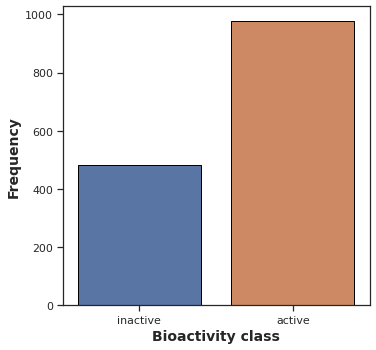

In [42]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

Scatter plot of MW versus LogP
It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

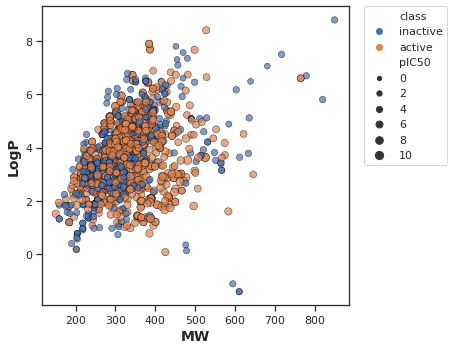

In [43]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

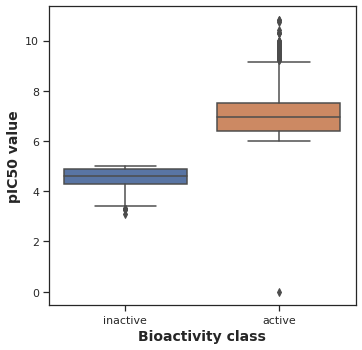

In [44]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

Statistical analysis | Mann-Whitney U Test

In [45]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [46]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,481.0,9.214458e-212,0.05,Different distribution (reject H0)


MW

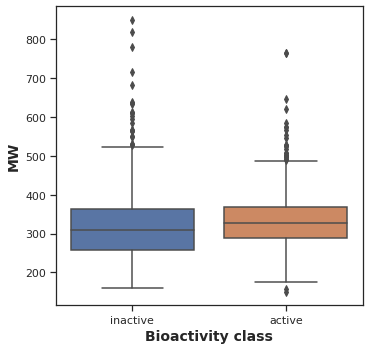

In [47]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [48]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,204412.5,0.000021,0.05,Different distribution (reject H0)


LogP

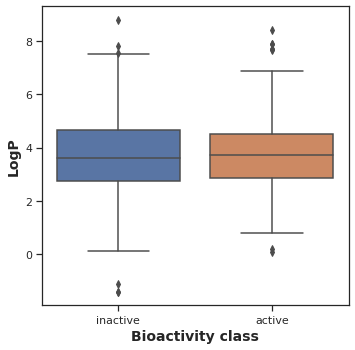

In [49]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [50]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,234418.5,0.445872,0.05,Same distribution (fail to reject H0)


NumHDonors

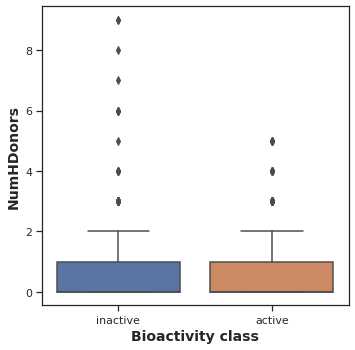

In [51]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [52]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,220089.5,0.010759,0.05,Different distribution (reject H0)


NumHAcceptors

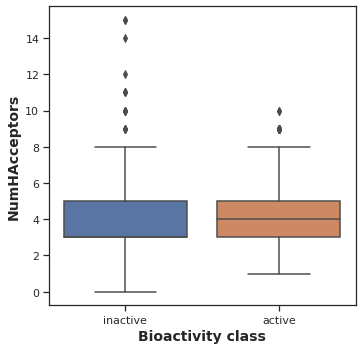

In [53]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [54]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,219560.0,0.016299,0.05,Different distribution (reject H0)


#Interpretation of Statistical Results

# Box Plots
pIC50 values
Taking a look at pIC50 values, the actives and inactives displayed statistically significant difference, which is to be expected since threshold values (IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives, corresponding to pIC50 > 6 = Actives and pIC50 < 5 = Inactives) were used to define actives and inactives.

Lipinski's descriptors
All of the 4 Lipinski's descriptors exhibited statistically significant difference between the actives and inactives.

In [55]:
! zip -r results.zip . -i *.csv *.pdf

  adding: plot_LogP.pdf (deflated 38%)
  adding: aromatase_04_bioactivity_data_3class_pIC50.csv (deflated 76%)
  adding: mannwhitneyu_LogP.csv (deflated 8%)
  adding: mannwhitneyu_MW.csv (deflated 9%)
  adding: plot_MW_vs_LogP.pdf (deflated 3%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 11%)
  adding: aromatase_03_bioactivity_data_curated.csv (deflated 81%)
  adding: plot_MW.pdf (deflated 37%)
  adding: plot_bioactivity_class.pdf (deflated 38%)
  adding: plot_ic50.pdf (deflated 37%)
  adding: aromatase_05_bioactivity_data_2class_pIC50.csv (deflated 76%)
  adding: aromatase_02_bioactivity_data_preprocessed.csv (deflated 79%)
  adding: plot_NumHDonors.pdf (deflated 38%)
  adding: aromatase_01_bioactivity_data_raw.csv (deflated 90%)
  adding: plot_NumHAcceptors.pdf (deflated 38%)
  adding: mannwhitneyu_pIC50.csv (deflated 10%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 11%)


Calculating molecular fingerprints using padelpy
Install padelpy¶

In [56]:
! pip install padelpy

     |████████████████████████████████| 20.9 MB 1.3 MB/s 


Prepare fingerprint XML
Download fingerprint XML files¶

In [57]:

!wget https://github.com/yejide/Computational-Drug-Design-using-machine-learning-with-python/blob/main/fingerprints_xml.zip


--2021-09-15 11:13:25--  https://github.com/yejide/Computational-Drug-Design-using-machine-learning-with-python/blob/main/fingerprints_xml.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘fingerprints_xml.zip.1’

fingerprints_xml.zi     [ <=>                ] 126.88K  --.-KB/s    in 0.04s   

2021-09-15 11:13:25 (3.23 MB/s) - ‘fingerprints_xml.zip.1’ saved [129921]



In [58]:
! unzip fingerprints_xml.zip

Archive:  fingerprints_xml.zip
  inflating: AtomPairs2DFingerprintCount.xml  
  inflating: AtomPairs2DFingerprinter.xml  
  inflating: EStateFingerprinter.xml  
  inflating: ExtendedFingerprinter.xml  
  inflating: Fingerprinter.xml       
  inflating: GraphOnlyFingerprinter.xml  
  inflating: KlekotaRothFingerprintCount.xml  
  inflating: KlekotaRothFingerprinter.xml  
  inflating: MACCSFingerprinter.xml  
  inflating: PubchemFingerprinter.xml  
  inflating: SubstructureFingerprintCount.xml  
  inflating: SubstructureFingerprinter.xml  


List and sort fingerprint XML files

In [59]:
import glob
xml_files = glob.glob("*.xml")
xml_files.sort()
xml_files

['AtomPairs2DFingerprintCount.xml',
 'AtomPairs2DFingerprinter.xml',
 'EStateFingerprinter.xml',
 'ExtendedFingerprinter.xml',
 'Fingerprinter.xml',
 'GraphOnlyFingerprinter.xml',
 'KlekotaRothFingerprintCount.xml',
 'KlekotaRothFingerprinter.xml',
 'MACCSFingerprinter.xml',
 'PubchemFingerprinter.xml',
 'SubstructureFingerprintCount.xml',
 'SubstructureFingerprinter.xml']

In [60]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

Create a dictionary


In [61]:
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2D': 'AtomPairs2DFingerprinter.xml',
 'AtomPairs2DCount': 'AtomPairs2DFingerprintCount.xml',
 'CDK': 'Fingerprinter.xml',
 'CDKextended': 'ExtendedFingerprinter.xml',
 'CDKgraphonly': 'GraphOnlyFingerprinter.xml',
 'EState': 'EStateFingerprinter.xml',
 'KlekotaRoth': 'KlekotaRothFingerprinter.xml',
 'KlekotaRothCount': 'KlekotaRothFingerprintCount.xml',
 'MACCS': 'MACCSFingerprinter.xml',
 'PubChem': 'PubchemFingerprinter.xml',
 'Substructure': 'SubstructureFingerprinter.xml',
 'SubstructureCount': 'SubstructureFingerprintCount.xml'}

In [62]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df_2class[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)


In [63]:
! cat smiles.txt

CHEMBL341591,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,7100.0
CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43C)[C@@H]1CC[C@@H]2[C@H]1CN1,50000.0
CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,238.0
CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,57.0
CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,54.0
CHEMBL324070,Cc1ccc(S(=O)(=O)n2cc(C(c3ccccc3)n3ccnc3)c3ccccc32)cc1,5400.0
CHEMBL41761,CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21,41.0
CHEMBL111868,Cn1cc(C(c2ccc(F)cc2)n2ccnc2)c2cc(Br)ccc21,78.5
CHEMBL111888,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2cc(Br)ccc21,51.8
CHEMBL112074,CCn1ccc2cc(C(c3ccccc3)n3ccnc3)ccc21,205.0
CHEMBL324326,N#Cc1ccc(Cn2cc(Cn3ccnc3)c3ccccc32)cc1,50.0
CHEMBL37321,CCCCCCN1C(=O)CCC(CC)(c2ccncc2)C1=O,6600.0
CHEMBL353068,c1ccc2c(c1)CCC1C(c3cc[nH]n3)C21,51000.0
CHEMBL41066,CCCCCCCC1(c2ccncc2)CCC(=O)NC1=O,3200.0
CHEMBL166709,O=C1/C(=C/c2cccnn2)CCc2ccccc21,250000.0
CHEMBL424556,O=C1/C(=C/c2ccnnc2)CCc2ccccc21,103000.0
CHEMBL1630273,C[C@]12CC[C@H]3[C@@H](CC=C4

In [64]:
! cat molecule.smi | head -5

C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43C)[C@@H]1CC[C@@H]2[C@H]1CN1	CHEMBL2111947
CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21	CHEMBL431859
CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21	CHEMBL113637
Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21	CHEMBL112021
CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21	CHEMBL41761


In [65]:
 ! cat molecule.smi | wc -l

1460


In [66]:
#! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
#! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

In [67]:
#! unzip padel.zip

In [68]:
#! cat padel.sh

In [69]:
#! bash padel.sh

In [70]:
#! ls -l

# Calculate fingerprint descriptors

Calculate descriptors
There are 12 fingerprint types in PaDEL. To calculate all 12, make sure to make adjustments to the descriptortypes input argument to any of the ones in the fp dictionary variable as shown above, e.g. SubstructureFingerprintCount.xml

In [71]:
from padelpy import padeldescriptor

fingerprint = 'Substructure'

fingerprint_output_file = ''.join([fingerprint,'.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='molecule.smi', 
                d_file=fingerprint_output_file, #'Substructure.csv'
                #descriptortypes='SubstructureFingerprint.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

# Display Calculated PaDEL descriptors

In [74]:
descriptors = pd.read_csv(fingerprint_output_file)

descriptors

,Name,SubFP1,SubFP2,SubFP3,SubFP4,SubFP5,SubFP6,SubFP7,SubFP8,SubFP9,SubFP10,SubFP11,SubFP12,SubFP13,SubFP14,SubFP15,SubFP16,SubFP17,SubFP18,SubFP19,SubFP20,SubFP21,SubFP22,SubFP23,SubFP24,SubFP25,SubFP26,SubFP27,SubFP28,SubFP29,SubFP30,SubFP31,SubFP32,SubFP33,SubFP34,SubFP35,SubFP36,SubFP37,SubFP38,SubFP39,...,SubFP268,SubFP269,SubFP270,SubFP271,SubFP272,SubFP273,SubFP274,SubFP275,SubFP276,SubFP277,SubFP278,SubFP279,SubFP280,SubFP281,SubFP282,SubFP283,SubFP284,SubFP285,SubFP286,SubFP287,SubFP288,SubFP289,SubFP290,SubFP291,SubFP292,SubFP293,SubFP294,SubFP295,SubFP296,SubFP297,SubFP298,SubFP299,SubFP300,SubFP301,SubFP302,SubFP303,SubFP304,SubFP305,SubFP306,SubFP307
0,CHEMBL431859,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
1,CHEMBL2111947,1,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
2,CHEMBL113637,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
3,CHEMBL112021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
4,CHEMBL41761,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,CHEMBL4568674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1
1456,CHEMBL4575939,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1
1457,CHEMBL4547558,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1
1458,CHEMBL4536893,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1


# Preparing the X and Y Data Matrices

In [75]:
X=descriptors.drop('Name',axis=1)
X



,SubFP1,SubFP2,SubFP3,SubFP4,SubFP5,SubFP6,SubFP7,SubFP8,SubFP9,SubFP10,SubFP11,SubFP12,SubFP13,SubFP14,SubFP15,SubFP16,SubFP17,SubFP18,SubFP19,SubFP20,SubFP21,SubFP22,SubFP23,SubFP24,SubFP25,SubFP26,SubFP27,SubFP28,SubFP29,SubFP30,SubFP31,SubFP32,SubFP33,SubFP34,SubFP35,SubFP36,SubFP37,SubFP38,SubFP39,SubFP40,...,SubFP268,SubFP269,SubFP270,SubFP271,SubFP272,SubFP273,SubFP274,SubFP275,SubFP276,SubFP277,SubFP278,SubFP279,SubFP280,SubFP281,SubFP282,SubFP283,SubFP284,SubFP285,SubFP286,SubFP287,SubFP288,SubFP289,SubFP290,SubFP291,SubFP292,SubFP293,SubFP294,SubFP295,SubFP296,SubFP297,SubFP298,SubFP299,SubFP300,SubFP301,SubFP302,SubFP303,SubFP304,SubFP305,SubFP306,SubFP307
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1
1456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1
1457,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1
1458,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1


# Y variable

# 3.4. Remove low variance features

In [76]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [77]:
from sklearn.feature_selection import VarianceThreshold

def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data[input_data.columns[selection.get_support(indices=True)]]

X = remove_low_variance(X, threshold=0.1)
X

,SubFP1,SubFP2,SubFP3,SubFP4,SubFP5,SubFP18,SubFP49,SubFP88,SubFP133,SubFP135,SubFP137,SubFP169,SubFP180,SubFP181,SubFP184,SubFP274,SubFP275,SubFP287,SubFP288,SubFP303
0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0
1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,0
1456,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0
1457,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0
1458,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0


In [78]:
X.to_csv('descriptor_list.csv', index = False)

# Y varaiable

In [80]:
Y=df_2class['pIC50']
Y

1       4.301030
2       6.623423
3       7.244125
4       7.267606
6       7.387216
          ...   
2047    7.239728
2048    7.916497
2049    7.400444
2050    7.042249
2053    6.113509
Name: pIC50, Length: 1460, dtype: float64

In [81]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [82]:
X_train.shape, Y_train.shape

((1168, 20), (1168,))

In [83]:
X_test.shape, Y_test.shape

((292, 20), (292,))

# 5. Building a Regression Model using Random Forest

In [84]:
model = RandomForestRegressor(n_estimators=100,random_state=50)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.30678099785864055

In [85]:
Y_pred = model.predict(X_test)
Y_pred

array([5.32018882, 5.82946354, 4.50669143, 4.83370202, 8.73902811,
       5.66485141, 6.76130381, 5.52517366, 7.62648641, 6.5494228 ,
       8.16316459, 5.39028323, 4.63187526, 4.55676852, 7.19142641,
       4.63187526, 5.54289384, 6.2607577 , 5.83786159, 4.51599626,
       6.90725727, 6.30910402, 8.16316459, 8.16316459, 4.77535225,
       6.76130381, 8.21031261, 6.76130381, 5.22546073, 6.5494228 ,
       6.896142  , 6.48951438, 6.34346529, 6.68347862, 7.30618056,
       4.50669143, 6.2607577 , 4.85385403, 6.2607577 , 7.62191909,
       4.50669143, 6.03616594, 6.17367213, 6.73506068, 6.36014428,
       4.5636075 , 7.2041679 , 5.94886432, 5.69311555, 6.76130381,
       6.91338743, 6.2607577 , 6.30920268, 5.23220221, 6.45285641,
       7.82599695, 6.51044008, 4.82531484, 5.6925044 , 7.30618056,
       8.16316459, 8.10557275, 4.46720361, 4.76442314, 6.45903307,
       8.16316459, 4.83370202, 6.37583115, 7.30618056, 6.53543869,
       5.17853122, 5.92683123, 6.17367213, 6.48743211, 6.91338

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


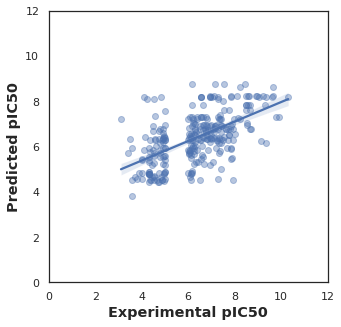

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show
plt.savefig('prediction_LogP.pdf')

In [87]:
import pickle
with open('modelregression.pickle', 'wb') as dump_var:
    pickle.dump(model, dump_var)

In [88]:
! pip install lazypredict

     |████████████████████████████████| 72 kB 636 kB/s 
     |████████████████████████████████| 302 kB 11.0 MB/s 
     |████████████████████████████████| 248 kB 25.6 MB/s 
     |████████████████████████████████| 14.5 MB 7.3 kB/s 
     |████████████████████████████████| 6.8 MB 42.5 MB/s 
     |████████████████████████████████| 127.6 MB 6.9 kB/s 
     |████████████████████████████████| 10.1 MB 148 kB/s 
     |████████████████████████████████| 25.9 MB 747 bytes/s 
     |████████████████████████████████| 82 kB 738 kB/s 
     |████████████████████████████████| 269 kB 40.4 MB/s 
     |████████████████████████████████| 1.2 MB 15.0 MB/s 
     |████████████████████████████████| 51 kB 117 kB/s 
     |████████████████████████████████| 97 kB 4.2 MB/s 
     |████████████████████████████████| 40 kB 3.6 MB/s 
     |████████████████████████████████| 53 kB 1.2 MB/s 
     |████████████████████████████████| 67 kB 3.3 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size

In [90]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import lazypredict
from lazypredict.Supervised import LazyRegressor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Compare ML algorithms

In [91]:
# Defines and builds the lazyclassifier
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_train,predictions_train = clf.fit(X_train, X_train, Y_train, Y_train)
models_test,predictions_test = clf.fit(X_train, X_test, Y_train, Y_test)

 97%|█████████▋| 37/38 [00:06<00:00,  5.92it/s]

[11:45:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 38/38 [00:00<00:00, 49207.64it/s]


In [92]:
import pickle
with open('allmodelregression.pickle', 'wb') as dump_var:
    pickle.dump(clf, dump_var)


In [93]:
predictions_train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreeRegressor,0.57,0.58,0.96,0.02
DecisionTreeRegressor,0.57,0.58,0.96,0.04
ExtraTreesRegressor,0.57,0.58,0.96,0.39
GaussianProcessRegressor,0.57,0.58,0.96,0.38
RandomForestRegressor,0.55,0.56,0.98,0.38
BaggingRegressor,0.54,0.55,0.99,0.05
HistGradientBoostingRegressor,0.47,0.48,1.06,0.65
LGBMRegressor,0.47,0.48,1.06,0.09
MLPRegressor,0.44,0.45,1.10,2.07


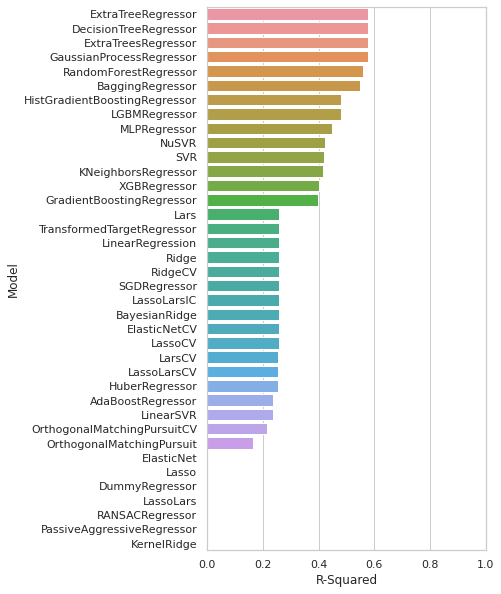

In [94]:
# Bar plot of R-squared values
import matplotlib.pyplot as plt
import seaborn as sns

#train["R-Squared"] = [0 if i < 0 else i for i in train.iloc[:,0] ]

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train)
ax.set(xlim=(0, 1))
plt.savefig('rsquare.pdf')

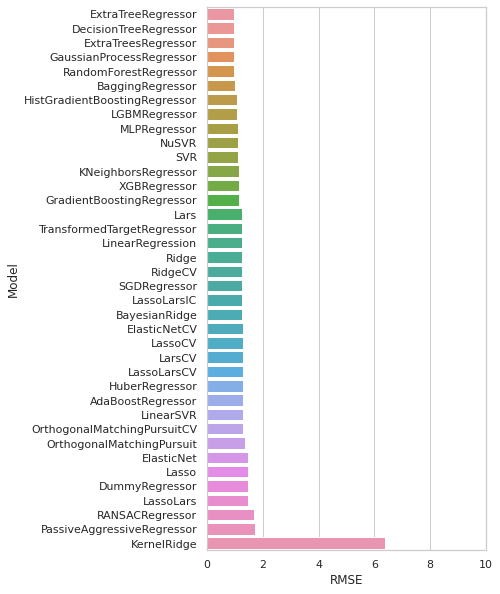

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train)
ax.set(xlim=(0, 10))
plt.savefig('rsme.pdf')

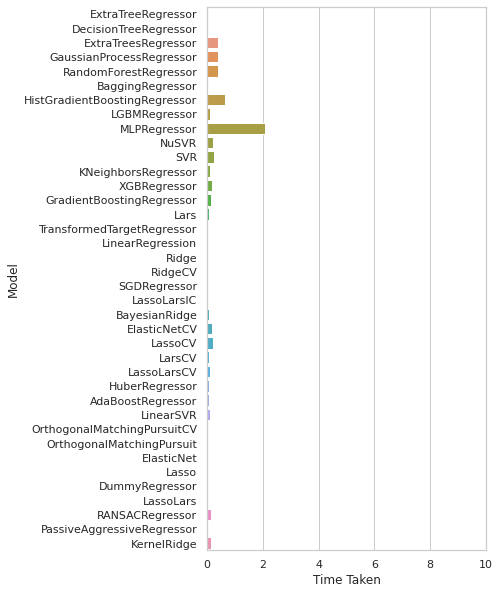

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train)
ax.set(xlim=(0, 10))
plt.savefig('mltime.pdf')